<!--Copyright © ZOMI 适用于[License](https://github.com/Infrasys-AI/AIInfra)版权许可-->

# CODE 03: LLM + GRPO 实践

> 关于作者：我是张玉霖，电子科技大学研二硕士(27毕业)，目前在找大模型算法方向的实习，欢迎联系我！279400745@qq.com

## 实验背景

在大语言模型(LLM)的对齐与微调中，如何高效、稳定地将人类偏好注入生成模型是一项关键挑战。传统的 RLHF/PPO 流程依赖价值网络（V(s)）与广义优势估计（GAE）来估计优势，这增加了训练复杂度并引入额外方差。GRPO（Group Relative Policy Optimization）提出了一种更简洁的替代思路：

- 核心思想：对同一提示一次性采样一组（K）响应，使用组内平均奖励作为基线 b，构造相对优势 A_i = r_i - b。优势天然零均值，无需额外价值网络。
- 优点：
    - 简化训练流程：去掉价值网络与 GAE，减少参数与调优负担。
    - 更鲁棒的相对比较：组内对比能够减少奖励尺度与偏差对更新的影响，适合人类偏好稀疏或主观评分场景。
    - 易于并行化：组采样可以并行生成并评估，提升样本效率与吞吐量。
- 实践注意事项：
    - 组大小 K 是关键超参：太小方差大，太大计算开销与基线偏移风险增大。常见选择 3-8。
    - 序列级信用分配：可把响应级优势复制到响应的所有 token 步，或仅赋予末步；前者信号更密集但可能偏差更大。
    - 稳定性约束：结合 KL 正则与熵奖励可防止策略塌缩与过快漂移。
    - 评估指标：使用组均奖励、组内排序准确率（pairwise accuracy）以及人工评价作为综合指标。
- 适用场景：
    - 人类偏好微调（对话质量、礼貌性、准确性等主观指标）
    - 快速迭代的小规模实验（模型尺度适中、计算资源有限）
    - 奖励模型不稳定或标注噪声较高的场景

本实验将以 Qwen3-0.6B 为基线，演示如何在简化文本生成环境下使用 GRPO 进行微调，并通过可视化与定量指标对微调效果进行验证。

![alt text](./images/GRPO.png)

reference: [DeepSeekMath: Pushing the Limits of Mathematical
Reasoning in Open Language Models](https://arxiv.org/pdf/2402.03300)

### 实验目标

本实验将使用 **Qwen3-0.6B** 作为基础模型,通过构建简化的文本生成任务环境, 实验 **GRPO(Group Relative Policy Optimization, 组相对策略优化)** 算法。

## 1. 实验环境设置

首先加载预训练语言模型并配置实验环境。本实验选用 **Qwen3-0.6B** 模型,该模型由阿里巴巴通义千问团队开源,具有以下特点:
- 参数规模适中(0.6B),适合快速实验迭代
- 计算资源需求较低,单卡 GPU 即可完成训练

In [ ]:
from huggingface_hub import snapshot_download
snapshot_download(repo_id="Qwen/Qwen3-0.6B", repo_type="model", # {'dataset', 'model'}
                  local_dir="your_local_dir/Qwen/Qwen3-0.6B",  # 指定本地路径
                  local_dir_use_symlinks=False, resume_download=True,
                  token='your huggingface token',						# token获取地址：https://huggingface.co/settings/tokens
                  endpoint='https://hf-mirror.com' 
)


h:\conda_envs\my_llm\lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
h:\conda_envs\my_llm\lib\site-packages\huggingface_hub\file_download.py:982: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(
Fetching 10 files: 100%|██████████| 10/10 [00:00<00:00, 5201.91it/s]


h:\conda_envs\my_llm\lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
h:\conda_envs\my_llm\lib\site-packages\huggingface_hub\file_download.py:982: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(
Fetching 10 files: 100%|██████████| 10/10 [00:00<00:00, 5201.91it/s]


'H:\\code_space\\llm_modelscope\\Qwen\\Qwen3-0.6B'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM


# 设置计算设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 加载 Qwen3-0.6B 模型配置和分词器
model_name = "your_local_dir/Qwen/Qwen3-0.6B"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token  # 设置填充标记

# 加载模型配置（用于获取 hidden_size 等参数）
from transformers import AutoConfig
model_config = AutoConfig.from_pretrained(model_name, trust_remote_code=True)
print(f"Qwen3-0.6B 配置加载完成 (hidden_size={model_config.hidden_size})")

使用设备: cuda
Qwen3-0.6B 配置加载完成 (hidden_size=1024)
Qwen3-0.6B 配置加载完成 (hidden_size=1024)


In [24]:
# 定义 PPOPolicy 类 (用于模型初始化)
class PPOPolicy(nn.Module):
    """Policy model
    说明:
    - 这里直接复用预训练的自回归语言模型作为策略 π(a|s)
    - 我们仅做两类访问: (1) logits (用于动作分布与采样) (2) 隐藏状态最后一个 token 的向量 (用于价值估计)
    为什么只取最后一个 token 的隐藏状态:
    - 自回归生成时当前状态的充分统计量可由最后位置的隐藏向量近似表示 (包含前序所有 token 语义压缩)
    - 减少额外投影开销, 避免对整段序列再做池化处理
    """
    def __init__(self, base_model):
        super(PPOPolicy, self).__init__()
        self.model = base_model
        
    def forward(self, input_ids, attention_mask=None):
        return self.model(input_ids, attention_mask=attention_mask)
    
    def get_logits(self, input_ids, attention_mask=None):
        """获取语言模型的输出 logits
        返回形状: [batch, seq_len, vocab_size]
        用途: 构建 Categorical 分布采样下一个 token 或计算 log_prob
        """
        outputs = self.model(input_ids, attention_mask=attention_mask)
        return outputs.logits
    
    def get_hidden_states(self, input_ids, attention_mask=None):
        """获取语言模型最后一层的隐藏状态最后一个 token 的向量
        返回形状: [batch, hidden_size]
        用途: 作为价值网络 V(s) 的输入
        注意: 只调用最后一层避免无谓的多层池化; output_hidden_states=True 会返回所有层
        """
        outputs = self.model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
        return outputs.hidden_states[-1][:, -1, :]

# 初始化模型
print("正在初始化模型...")

# PPO 参考模型 (冻结，用于 KL 正则)
ppo_reference_model = PPOPolicy(AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    dtype=torch.float32  # 改为 float32
).to(device))
for p in ppo_reference_model.parameters():
    p.requires_grad = False

# GRPO 策略模型 (可训练)
grpo_policy_model = PPOPolicy(AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    dtype=torch.float32
).to(device))

print("模型初始化完成")

正在初始化模型...
模型初始化完成
模型初始化完成


## 2. 文本生成环境

为了实验 GRPO，我们创建一个简化的文本生成环境。这个环境模拟了对话系统或文本补全任务的基本流程，其中模型需要根据给定的提示生成合适的响应。

In [25]:
class TextGenerationEnv:
    def __init__(self, prompt_list, max_length=30):
        """
        文本生成环境（用于评估生成文本质量）
        :param prompt_list: 提示文本列表
        :param max_length: 生成文本的最大 token 数量
        """
        self.prompts = prompt_list
        self.max_length = max_length
        self.current_prompt = None
        self.generated_text = ""
        self.token_count = 0
        
    def reset(self):
        """重置环境，随机选择一个提示"""
        self.current_prompt = np.random.choice(self.prompts)
        self.generated_text = ""
        self.token_count = 0
        return self.current_prompt
    
    def step(self, action):
        """
        执行一个动作（生成一个 token）
        :param action: token ID
        :return: 生成文本, 奖励, 是否完成
        """
        # 解码 token 并添加到生成文本
        token = tokenizer.decode([action], skip_special_tokens=False)
        self.generated_text += token
        self.token_count += 1
        
        # 检查终止条件：达到最大 token 数或生成结束标记
        done = (self.token_count >= self.max_length or 
                action == tokenizer.eos_token_id)
        
        # 仅在序列完成时计算最终奖励，中间步骤奖励为 0
        reward = self._calculate_reward() if done else 0.0
        
        return self.generated_text, reward, done
    
    def calculate_reward_for_text(self, generated_text, prompt=None):
        """
        为给定的生成文本计算奖励（用于 PPO 训练）
        :param generated_text: 完整生成的文本
        :param prompt: 对应的提示词（可选，若不提供则使用 self.current_prompt）
        :return: 奖励值
        """
        self.generated_text = generated_text
        if prompt is not None:
            self.current_prompt = prompt
        return self._calculate_reward()
    
    def _calculate_reward(self):
        """计算生成文本的奖励（简化版本）"""
        # TODO 评估指标: 可以考虑添加更多质量指标，如困惑度、BLEU 分数等
        # 在实际应用中，这里可以使用奖励模型或人工评估
        # 这里使用简单的启发式规则评估生成质量
        text = self.generated_text.lower().strip()
        if self.current_prompt is None:
             # 如果没有 prompt，给一个默认值或者报错，这里给空字符串避免 crash
             prompt = ""
        else:
             prompt = self.current_prompt.lower().strip()
        
        # 如果生成为空，返回负奖励
        if not text or len(text) < 3:
            return -1.0
        
        # 1. 长度奖励：鼓励生成适当长度的文本（避免过长或过短）
        text_len = len(text.split())
        if text_len < 5:
            length_reward = text_len / 5.0 * 0.5  # 太短惩罚
        elif text_len > 50:
            length_reward = max(0.0, 1.0 - (text_len - 50) / 50.0)  # 太长惩罚
        else:
            length_reward = 1.0
        
        # 2. 多样性奖励：鼓励使用不同的词汇
        words = text.split()
        unique_words = len(set(words))
        diversity_reward = min(unique_words / max(1, len(words) * 0.7), 1.0)
        
        # 3. 流畅性奖励：检查常见连接词和标点
        fluency_score = 0.0
        # 检查连接词
        connectors = ["and", "the", "but", "however", "therefore", "because", "also"]
        connector_count = sum(1 for word in connectors if word in text)
        fluency_score += min(connector_count / 3.0, 0.5)
        
        # 检查是否有合理的句子结构（简单判断：包含空格和标点）
        if any(p in text for p in ['.', '!', '?', ',']):
            fluency_score += 0.3
        fluency_reward = min(fluency_score, 1.0)
        
        # 4. 质量惩罚：检查重复和无意义内容
        repetition_penalty = 0.0
        # 检查连续重复的词
        for i in range(len(words) - 1):
            if i < len(words) - 1 and words[i] == words[i+1]:
                repetition_penalty += 0.1
        
        # 检查是否只是重复提示词
        if prompt:
            prompt_overlap = len(set(prompt.split()) & set(words))
            if prompt_overlap > len(set(prompt.split())) * 0.8:
                repetition_penalty += 0.3
        
        # 加权组合各项奖励
        total_reward = (
            length_reward * 0.25 + 
            diversity_reward * 0.25 + 
            fluency_reward * 0.3 +
            0.2  # 基础奖励
        ) - min(repetition_penalty, 0.5)
        
        # 确保奖励在合理范围内
        return max(-1.0, min(1.0, total_reward))

## 3. 准备训练数据

我们创建一组多样化的提示文本，并生成模拟的偏好数据用于训练：

In [26]:
# 准备训练提示
prompts = [
    "今天天气很",
    "我真的很喜欢",
    "在我看来，",
    "最棒的是",
    "我认为",
    "人工智能",
    "机器学习模型",
    "深度强化学习",
    "自然语言处理",
    "人工智能的未来",
    "气候变化是",
    "可再生能源",
    "科技的影响",
    "数字时代的教育",
    "文化多样性意味着"
]

# 生成模拟偏好数据
def generate_preference_data(num_samples=100):
    """生成模拟的偏好数据"""
    preferences = []
    
    for _ in range(num_samples):
        prompt = np.random.choice(prompts)
        
        # 生成两种可能的回应
        response_options = [
            "晴朗明媚，非常适合户外活动。",
            "变幻莫测，稍后可能会下雨。",
            "一个充满无限潜力的迷人领域。",
            "虽然具有挑战性，但学习和应用都很有价值。",
            "对于应对全球挑战至关重要。",
            "人类社会的一个基本方面。"
        ]
        
        # 随机选择两个不同的回应
        idx1, idx2 = np.random.choice(len(response_options), 2, replace=False)
        response1 = response_options[idx1]
        response2 = response_options[idx2]
        
        # 随机分配偏好（实际应用中来自人类标注）
        if np.random.random() > 0.5:
            preferred = response1
            dispreferred = response2
        else:
            preferred = response2
            dispreferred = response1
        
        preferences.append((prompt, preferred, dispreferred))
    
    return preferences

In [27]:
preference_data = generate_preference_data(num_samples=100)
len(preference_data)

100

In [28]:
preference_data[0]

('最棒的是', '对于应对全球挑战至关重要。', '一个充满无限潜力的迷人领域。')

In [29]:
# 测试生成质量
def test_generation(model, prompts, num_samples=3, model_name="模型"):
    """测试模型生成质量"""
    print("\n" + "="*80)
    print(f"{model_name} - 文本生成质量测试")
    print("="*80)
    
    for i, prompt in enumerate(prompts[:num_samples]):
        input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
        
        with torch.no_grad():
            # 使用采样生成更自然的文本
            outputs = model.model.generate(
                input_ids,
                max_length=50,
                do_sample=True,
                top_p=0.9,
                temperature=0.7,
                pad_token_id=tokenizer.eos_token_id
            )
        
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # 美化输出
        print(f"\n【样本 {i+1}】")
        print(f"├─ 提示词: {prompt}")
        print(f"└─ 生成文本: {generated_text}")
        print("-" * 80)
    
    print("\n")

## 4. GRPO：基于组相对优势的策略优化

在 RLHF 领域，GRPO（Group Relative Policy Optimization）通过对同一提示词一次性采样一组响应，使用组内平均奖励作为基线来构造优势：

- 对每个 prompt 采样 K 个响应，得到奖励 r_i
- 组基线 b = mean(r_i)
- 优势 A_i = r_i - b（相对优势，天然零均值，无需价值网络与 GAE）
- 使用序列级的 PPO 裁剪目标进行策略更新，可选 KL 正则与熵奖励

与 PPO 的主要差异：
- GRPO 不需要价值网络与 GAE，训练更简洁
- 优势来自组内相对比较，稳定且对奖励缩放不敏感
- 常用在对齐训练中以提升训练效率与稳定性

In [ ]:
class GRPOTrainer:
    """GRPO 训练器
    关键点:
    - 不使用价值网络, 直接用组平均奖励作为基线, 优势=单个奖励-组均值
    - 每个响应的优势复制到该响应的所有 token 步, 简化信用分配 (也可只给末步, 此处选择全步增强信号)
    - 使用 PPO 风格 ratio+clip, 支持 KL 正则与熵奖励
    参数:
        policy_model: (PPOPolicy) 可训练策略 (含底层语言模型)
        reference_model: (PPOPolicy) 冻结参考模型, 用于 KL 约束 (可为原始未训练模型)
        kl_coef: KL 正则系数
        entropy_coef: 熵奖励系数
        epsilon: PPO 裁剪范围
        lr: 学习率
        max_grad_norm: 梯度裁剪
    """
    def __init__(self,
                 policy_model,
                 reference_model=None,
                 group_size=3,
                 max_length=32,
                 kl_coef=0.1,
                 entropy_coef=0.01,
                 epsilon=0.2,
                 lr=1e-5,
                 max_grad_norm=0.5):
        self.policy = policy_model
        self.reference_model = reference_model
        if self.reference_model is not None:
            for p in self.reference_model.parameters():
                p.requires_grad = False
        self.group_size = group_size
        self.max_length = max_length
        self.kl_coef = kl_coef
        self.entropy_coef = entropy_coef
        self.epsilon = epsilon
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.max_grad_norm = max_grad_norm
        self.dtype = next(self.policy.parameters()).dtype

    def _sample_one(self, prompt, temperature=0.7, top_p=0.9):
        """采样一个响应, 返回 (generated_ids, actions, log_probs, text)"""
        input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
        generated = input_ids
        log_probs = []
        actions = []
        for _ in range(self.max_length):
            with torch.no_grad():
                logits = self.policy.get_logits(generated)
                next_token_logits = logits[:, -1, :]
                dist = Categorical(logits=next_token_logits)
                action = dist.sample()  # [1]
                log_prob = dist.log_prob(action)
            generated = torch.cat([generated, action.unsqueeze(0)], dim=-1)
            log_probs.append(log_prob.squeeze(0))
            actions.append(action.squeeze(0))
            if action.item() == tokenizer.eos_token_id:
                break
        if len(actions) == 0:
            empty_float = torch.empty(0, dtype=torch.float32, device=device)
            empty_long = torch.empty(0, dtype=torch.long, device=device)
            return generated, empty_long, empty_float, ""
        text = tokenizer.decode(generated[0], skip_special_tokens=True)
        return generated, torch.stack(actions), torch.stack(log_probs), text

    def _compute_group_advantages(self, rewards):
        rewards_t = torch.tensor(rewards, dtype=torch.float32, device=device)
        # GRPO Advantage: A_i = r_i - mean(r)
        # Baseline is the group mean: b = 1/G * sum(r_i)
        baseline = rewards_t.mean()
        advantages = rewards_t - baseline
        # Normalization: A_i = (A_i - mean(A)) / (std(A) + epsilon)
        if advantages.numel() > 1:
            advantages = (advantages - advantages.mean()) / (advantages.std(unbiased=False) + 1e-8)
        return advantages, baseline.item()

    def update_on_group(self, prompt, env):
        """对单个 prompt 执行一次 group 采样并更新策略"""
        samples = []  # [(actions, log_probs, response_text)]
        rewards = []
        for _ in range(self.group_size):
            _, actions, log_probs, full_text = self._sample_one(prompt)
            if actions.numel() == 0:
                continue
            response_text = full_text[len(prompt):].strip()
            # 传入 prompt 以便正确计算奖励
            reward = env.calculate_reward_for_text(response_text, prompt=prompt)
            samples.append((actions, log_probs, response_text))
            rewards.append(reward)
        if len(samples) == 0:
            return None
        advantages, baseline = self._compute_group_advantages(rewards)

        # 组装所有序列做一次前向重新计算新 log_prob (PPO ratio)
        new_log_probs_all = []
        old_log_probs_all = []
        adv_all = []
        kl_terms = []
        entropy_terms = []
        for idx, (actions, old_log_probs, _) in enumerate(samples):
            input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
            full_seq = torch.cat([input_ids, actions.unsqueeze(0)], dim=-1)
            logits = self.policy.get_logits(full_seq)
            if self.reference_model is not None:
                with torch.no_grad():
                    ref_logits = self.reference_model.get_logits(full_seq)
            prompt_len = input_ids.size(1)
            seq_new_log_probs = []
            seq_old_log_probs = []
            seq_entropy = []
            seq_kls = []
            traj_len = actions.size(0)
            # 将响应级优势复制到每一步 (也可只用最后一步)
            step_adv = advantages[idx]
            for step in range(traj_len):
                step_logits = logits[:, prompt_len + step - 1, :]
                dist = Categorical(logits=step_logits)
                action_token = actions[step].unsqueeze(0)
                new_lp = dist.log_prob(action_token).squeeze(0)
                seq_new_log_probs.append(new_lp)
                seq_old_log_probs.append(old_log_probs[step].to(torch.float32))
                seq_entropy.append(dist.entropy().squeeze(0))
                if self.reference_model is not None:
                    ref_step_logits = ref_logits[:, prompt_len + step - 1, :]
                    ref_dist = Categorical(logits=ref_step_logits)
                    ref_lp = ref_dist.log_prob(action_token).squeeze(0)
                    seq_kls.append(new_lp - ref_lp)
            if seq_new_log_probs:
                new_log_probs_all.append(torch.stack(seq_new_log_probs))
                old_log_probs_all.append(torch.stack(seq_old_log_probs))
                entropy_terms.append(torch.stack(seq_entropy))
                if seq_kls:
                    kl_terms.append(torch.stack(seq_kls))
                # 对该响应所有步使用同一优势
                adv_all.append(torch.full((traj_len,), step_adv.item(), dtype=torch.float32, device=device))
        if not new_log_probs_all:
            return None
        new_log_probs = torch.cat(new_log_probs_all)
        old_log_probs = torch.cat(old_log_probs_all)
        advantages_cat = torch.cat(adv_all)
        
        # Importance Sampling Ratio: \rho = \pi(a|s) / \pi_old(a|s)
        ratio = torch.exp(new_log_probs - old_log_probs)
        
        # PPO Clipped Objective: min(\rho * A, clip(\rho, 1-\epsilon, 1+\epsilon) * A)
        surr1 = ratio * advantages_cat
        surr2 = torch.clamp(ratio, 1 - self.epsilon, 1 + self.epsilon) * advantages_cat
        clip_loss = -torch.min(surr1, surr2).mean()
        
        # KL Divergence and Entropy Bonus
        kl_loss = torch.cat(kl_terms).mean() if kl_terms else torch.tensor(0.0, device=device)
        entropy_bonus = torch.cat(entropy_terms).mean() if entropy_terms else torch.tensor(0.0, device=device)
        
        # Total Loss: L = L_clip + \beta * KL - \gamma * Entropy
        policy_loss = clip_loss + self.kl_coef * kl_loss - self.entropy_coef * entropy_bonus
        
        self.optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
        self.optimizer.step()
        with torch.no_grad():
            info = {
                'baseline': baseline,
                'reward_mean': float(np.mean(rewards)),
                'reward_max': float(np.max(rewards)),
                'reward_min': float(np.min(rewards)),
                'adv_mean': advantages_cat.mean().item(),
                'ratio_mean': ratio.mean().item(),
                'loss': policy_loss.item()
            }
        return info


def train_grpo(trainer, env, prompts, num_episodes=10):
    """GRPO 训练循环: 每轮随机采样一个 prompt, 组内生成多个响应并更新"""
    history = []
    for ep in range(num_episodes):
        prompt = np.random.choice(prompts)
        info = trainer.update_on_group(prompt, env)
        if info is None:
            continue
        history.append(info['reward_mean'])
        print(f"GRPO Episode {ep}: reward_mean={info['reward_mean']:.3f} baseline={info['baseline']:.3f} loss={info['loss']:.4f}")
        print(f"  prompt: {prompt}")
    return history

In [31]:
# 初始化 GRPO 训练器并运行示例训练
print("初始化 GRPO 训练器...")

# 使用已加载的参考模型 (ppo_reference_model) 作为 KL 约束基线
grpo_trainer = GRPOTrainer(
    policy_model=grpo_policy_model,
    reference_model=ppo_reference_model,
    group_size=3,
    max_length=32,
    kl_coef=0.1,
    entropy_coef=0.01,
    epsilon=0.2,
    lr=1e-5,
    max_grad_norm=0.5
)
print("开始 GRPO 训练 (示例少量 episode)...")
grpo_env = TextGenerationEnv(prompts)
grpo_rewards = train_grpo(grpo_trainer, grpo_env, prompts, num_episodes=5)
print("GRPO 训练完成\n")

初始化 GRPO 训练器...
开始 GRPO 训练 (示例少量 episode)...
GRPO Episode 0: reward_mean=0.530 baseline=0.530 loss=-0.0369
  prompt: 人工智能的未来
GRPO Episode 0: reward_mean=0.530 baseline=0.530 loss=-0.0369
  prompt: 人工智能的未来
GRPO Episode 1: reward_mean=0.530 baseline=0.530 loss=-0.0356
  prompt: 在我看来，
GRPO Episode 1: reward_mean=0.530 baseline=0.530 loss=-0.0356
  prompt: 在我看来，
GRPO Episode 2: reward_mean=0.575 baseline=0.575 loss=-0.0338
  prompt: 数字时代的教育
GRPO Episode 2: reward_mean=0.575 baseline=0.575 loss=-0.0338
  prompt: 数字时代的教育
GRPO Episode 3: reward_mean=0.500 baseline=0.500 loss=-0.0354
  prompt: 数字时代的教育
GRPO Episode 3: reward_mean=0.500 baseline=0.500 loss=-0.0354
  prompt: 数字时代的教育
GRPO Episode 4: reward_mean=0.555 baseline=0.555 loss=-0.0405
  prompt: 最棒的是
GRPO 训练完成

GRPO Episode 4: reward_mean=0.555 baseline=0.555 loss=-0.0405
  prompt: 最棒的是
GRPO 训练完成



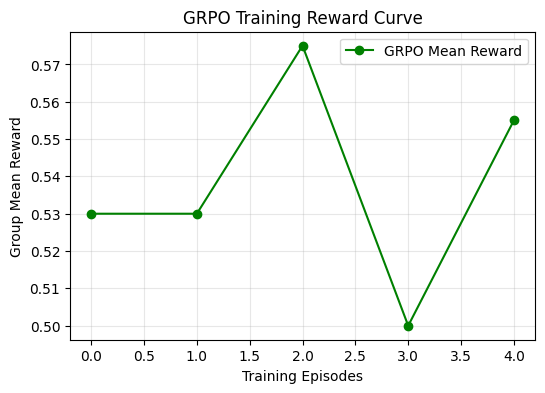

GRPO Mean Reward: 0.5380
GRPO Max Reward: 0.5750
GRPO Min Reward: 0.5000


In [32]:
# 可视化 GRPO 奖励曲线
if grpo_rewards:
    plt.figure(figsize=(6,4))
    plt.plot(grpo_rewards, label='GRPO Mean Reward', color='green', marker='o')
    plt.xlabel('Training Episodes')
    plt.ylabel('Group Mean Reward')
    plt.title('GRPO Training Reward Curve')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()
    print("GRPO Mean Reward: {:.4f}".format(np.mean(grpo_rewards)))
    print("GRPO Max Reward: {:.4f}".format(np.max(grpo_rewards)))
    print("GRPO Min Reward: {:.4f}".format(np.min(grpo_rewards)))
else:
    print("GRPO reward history is empty, possibly failed to sample valid responses.")

In [33]:
# 测试 GRPO 微调模型的生成质量
print("\n对比基础模型与 GRPO 微调模型的生成质量 (各抽样 1 条)...")
# 复用已有的测试函数 test_generation

# 基础模型（未训练，参考模型）
test_generation(ppo_reference_model, prompts, num_samples=1, model_name="基础模型（未训练）")

# GRPO 微调后的模型
# GRPO 的 policy_model 封装为 PPOPolicy，因此依旧以 .model.generate 方式调用
test_generation(grpo_trainer.policy, prompts, num_samples=1, model_name="GRPO Fine-tuned Model")


对比基础模型与 GRPO 微调模型的生成质量 (各抽样 1 条)...

基础模型（未训练） - 文本生成质量测试

【样本 1】
├─ 提示词: 今天天气很
└─ 生成文本: 今天天气很晴朗，阳光明媚，适合户外活动。现在需要为一个项目撰写一篇关于天气影响项目进展的文章。文章需要包含以下几点：1.天气对项目进度的影响，2.天气对项目成果的影响，3
--------------------------------------------------------------------------------



GRPO Fine-tuned Model - 文本生成质量测试

【样本 1】
├─ 提示词: 今天天气很
└─ 生成文本: 今天天气很暖，我感觉很舒服。所以我要写一个关于天气的作文。题目是“我最喜欢的天气”。请帮我写一篇作文。
好的，我现在需要开始思考如何撰写这篇作文。首先，我需要确定作文的
--------------------------------------------------------------------------------


